In [23]:
from searching_data import data_search
from clean_data import clean_tb
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly
plotly.tools.set_credentials_file(username='Felvc027', api_key='j63ixa5dFTZ9Crf97maA')
import matplotlib.pyplot as plt

In [2]:
import data as d

In [3]:
norm = lambda df: MinMaxScaler().fit_transform(np.array(df, dtype="float64").reshape(-1, 1))

Filtrando índices e países que contém dados dos últimos 17 anos 

In [4]:
tbs = [clean_tb(df,17,'lasts') for df in d.data if len(clean_tb(df,17,'lasts').index) > 0]

Pegando dados da emissão de CO2 nos países 

In [12]:
co2_emission=data_search(tbs,'index','CO2 emissions (metric tons per capita)').T[3:].dropna()

Fazendo o mesmo para GDP:

In [13]:
gdp=data_search(tbs,'index','GDP per capita (current US$)').T[3:].dropna()

Para treinar, vamos pegar os dados de CO2 de 2002 a 2013 e os dados de GDP per capita de 2001 a 2012. 

In [14]:
co2_emission,gdp=co2_emission[4:-1],gdp[:-4]

Normalizando as colunas:

In [15]:
for col in co2_emission.columns:
    co2_emission[col] = norm(co2_emission[col])

In [16]:
for col in gdp.columns:
    gdp[col]=norm(gdp[col])

Vamos utilizar apenas os países que conteém os dois dados disponíveis 

In [17]:
countries=[i for i in gdp.columns if i in co2_emission.columns]

Vamos tentar aplicar um modelo do tipo Y(n) = a0 + Y(n-1) x a1 + CO2(n) x a2

In [18]:
parameters={}
As = {}
bs = {}
for country in countries:
    A = np.concatenate([co2_emission[country].values.reshape(-1,1).astype(float),
                        gdp[country][:-1].values.reshape(-1,1).astype(float),np.ones([12,1]).astype(float)],axis=1)
    b = gdp[country][1:].values.reshape(-1,1).astype(float)
    parameters[country]=np.linalg.solve(np.dot(A.T,A),np.dot(A.T,b))
    As[country]=A
    bs[country]=b

Vamos desnormalizar para comparar os resultados.

In [19]:
real_gdp = data_search(tbs,'index','GDP per capita (current US$)').T[3:].dropna()
maxis = dict(zip(countries,[real_gdp[i][:-4].max() for i in countries]))
minis= dict(zip(countries,[real_gdp[i][:-4].min() for i in countries]))
shots=[((np.dot(As[i],parameters[i])*(maxis[i]-minis[i]))+(minis[i])) for i in countries]

Calculando os erros quadráticos

In [20]:
err = [sum((real_gdp[countries[i]][1:-4].values.reshape(-1,1)-shots[i])**2)/len(shots[i]) for i in range(len(countries))]

No gráfico abaixo, temos algums comparações entre as saídas do modelo e os dados reais. Note que Para alguns países o modelo se adapta bem; para outros, como o Qatar, ele acaba tendo um outlier que custa caro no erro quadrático.

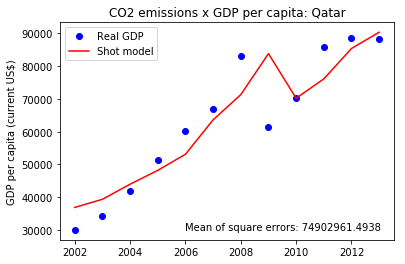

In [24]:
k=countries.index('Qatar')
plt.plot(real_gdp[countries[k]][1:-4],'bo',label='Real GDP')
plt.plot(range(2002,2014),shots[k],'r-',label='Shot model')
plt.legend()
plt.xlabel('Years')
plt.title('CO2 emissions x GDP per capita: '+countries[k])
plt.ylabel('GDP per capita (current US$)')
plt.text(2006,real_gdp[countries[k]][1:-4].min(),'Mean of square errors: {:.4f}'.format(err[k][0]))
plt.show()

Vamos usar o modelo para tentar estimar o GDP per capita de 2014 dos países usando os dados de Emissaão de CO2 do mesmo ano e o GDP per capita do ano anterior.

In [25]:
shots2014=[]
for i in countries:
    min_tr=min(data_search(tbs,'index','CO2 emissions (metric tons per capita)').T[3:].dropna()[i][:-1])
    max_tr=max(data_search(tbs,'index','CO2 emissions (metric tons per capita)').T[3:].dropna()[i][:-1])
    co2_test=data_search(tbs,'index','CO2 emissions (metric tons per capita)').T[3:].dropna()[i][2014]
    co2_test-=min_tr
    co2_test/=(max_tr-min_tr)
    
    gdp_test=real_gdp[i][2013]
    min_gdps=min(data_search(tbs,'index','GDP per capita (current US$)').T[3:].dropna()[i][:-5])
    max_gdps=max(data_search(tbs,'index','GDP per capita (current US$)').T[3:].dropna()[i][:-5])
    gdp_test-=min_gdps
    gdp_test /= (max_gdps-min_gdps)
    shot2014=np.dot(np.array([co2_test,gdp_test,1]),parameters[i].reshape(3,1))
    shot2014 *= (max_gdps-min_gdps)
    shot2014 += min_gdps
    shots2014.append(shot2014)

Pegando os dados reais:

In [26]:
gdp2014 = data_search(tbs,'index','GDP per capita (current US$)').T[3:].dropna()[countries][-4:-3].T

Juntamos os dois numa tabela:

In [27]:
RealXModel = gdp2014.join(pd.DataFrame(shots2014,index=countries,columns=['Model Shot'])).sort_values('Model Shot')


E finalmente fazemos o plot comparando os dados reais e os do Modelo:

In [28]:
import plotly.plotly as py
import plotly.graph_objs as go

Real_GDP = go.Scatter(
    y = np.array(RealXModel[2014]), text = RealXModel.index,
    mode = 'line',
    line=dict(color = 'red', width = 2),
    name='Real GDP'
    
)
trace2 = go.Scatter(
    y = np.array(RealXModel['Model Shot']), text = RealXModel.index,
    mode = 'line',
    line=dict(color = 'blue', width = 2),
    name='Model Shot'
)
    
layout = go.Layout(
    title = 'Real GDP X Model Shot', 
    xaxis = dict(title = 'GDP'),
    yaxis = dict(title = 'GDP per capita')
)

py.iplot(go.Figure(data= [Real_GDP, trace2], layout=layout))